# Loss-Based Membership Inference Attack with PrivacyGuard

## Introduction

We showcase a loss-based membership inference attack using PrivacyGuard. This tutorial will guide you through the process of conducting a loss-based membership inference attack on a machine learning model and analyzing the results.

### What is a Membership Inference Attack?

A membership inference attack (MIA) is a privacy attack that aims to determine whether a specific data point was used to train a machine learning model. These attacks exploit the fact that models often behave differently on data they were trained on compared to data they haven't seen before.

### Why Loss-Based Attacks?

Loss-based attacks are a common type of membership inference attack that use the loss value (or prediction error) of a model on a data point as a signal for membership. The intuition is that models typically have lower loss values on training data compared to unseen data. This difference can be exploited to infer membership.

### What We'll Cover

In this tutorial, we will:
1. Set up a simple classification problem using Gaussian data
2. Train a model on a subset of the data
3. Perform a loss-based membership inference attack using the `LossAttack` class
4. Analyze the attack results using the `LossAnalysisNode` class
5. Interpret the results and discuss privacy implications

Let's get started!

## Setup and Imports

First, let's import the necessary libraries and set up our environment.

In [56]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# Import Privacy Guard components
from privacy_guard.attacks.loss_attack import LossAttack
from privacy_guard.analysis.mia.analysis_node import AnalysisNode

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

## Generating Synthetic Data

We'll create a synthetic dataset for a binary classification problem using Gaussian distributions. This will serve as our example dataset for demonstrating the membership inference attack.

In [77]:
# Define parameters for the Gaussian mixture
n_class = 10  # Number of classes
n_train = 50 * n_class  # Number of training samples
n_test = 50 * n_class   # Number of test samples
sigma = 10  # Standard deviation of the Gaussian distributions
d = 1000    # Dimensionality of the feature space

In [78]:
# Generate training data
train_y = torch.arange(0, n_class).repeat_interleave(n_train // n_class)
class_centers = torch.randn(n_class, d)  # Random centers for each class
train_x = class_centers[train_y] + sigma * torch.randn(n_train, d)

# Generate test data
test_y = torch.arange(0, n_class).repeat_interleave(n_test // n_class)
test_x = class_centers[test_y] + sigma * torch.randn(n_test, d)

# Create datasets
trainset = TensorDataset(train_x, train_y)
testset = TensorDataset(test_x, test_y)

print(f"Training set shape: {train_x.shape}, {train_y.shape}")
print(f"Testing set shape: {test_x.shape}, {test_y.shape}")

Training set shape: torch.Size([500, 1000]), torch.Size([500])
Testing set shape: torch.Size([500, 1000]), torch.Size([500])


Let's visualize the first two dimensions of our data to get a sense of the separation between classes:

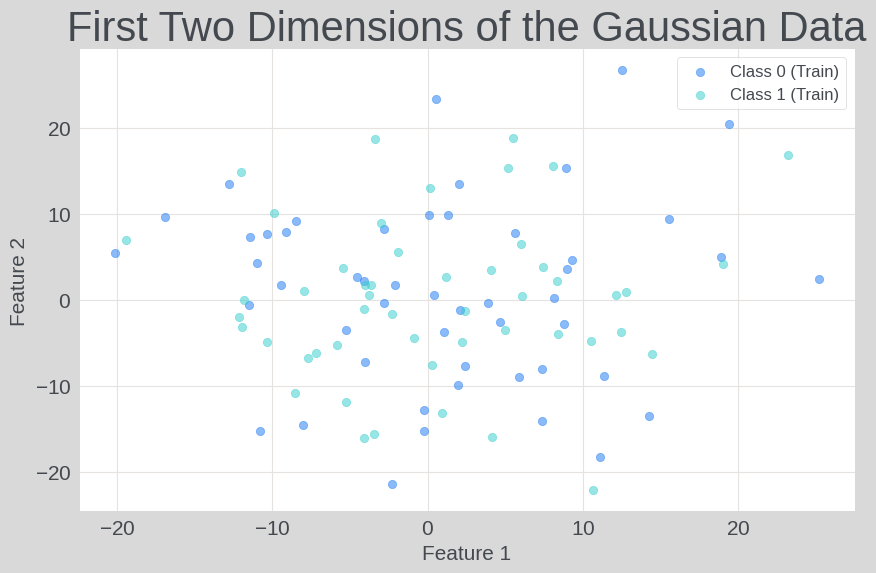

In [79]:
plt.figure(figsize=(10, 6))
plt.scatter(train_x[train_y == 0, 0], train_x[train_y == 0, 1], alpha=0.5, label='Class 0 (Train)')
plt.scatter(train_x[train_y == 1, 0], train_x[train_y == 1, 1], alpha=0.5, label='Class 1 (Train)')
plt.title('First Two Dimensions of the Gaussian Data')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.grid(True)
plt.show()

In [80]:
# Create data loaders
train_loader = DataLoader(trainset, batch_size=64)
test_loader = DataLoader(testset, batch_size=n_test)

## Training the Model

Now, let's train our model on the training data. We'll use cross-entropy loss and the Adam optimizer.

In [81]:
# Create a linear model
model = nn.Linear(d, n_class)
print(model)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()

# Training loop
losses = []
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)

for epoch in range(2):
    for inp, out in train_loader:
        loss = criterion(model(inp), out)
        optimizer.zero_grad()
        loss.backward()
        losses.append(loss.item())
        optimizer.step()

Linear(in_features=1000, out_features=10, bias=True)


Let's visualize the training loss over timesteps:

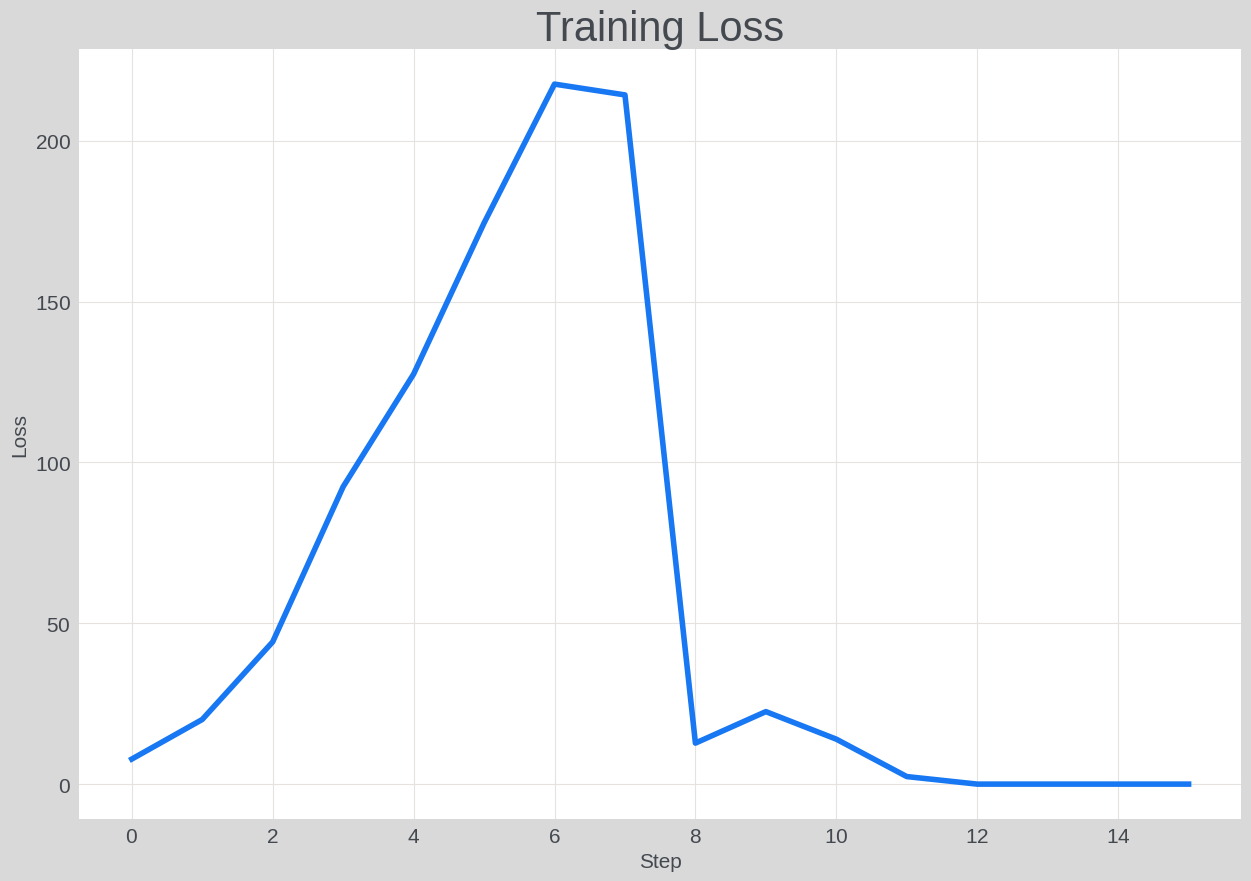

In [82]:
plt.plot(losses)
plt.ylabel("Loss")
plt.xlabel("Step")
plt.title("Training Loss")
plt.show()

## Performing a Loss-Based Membership Inference Attack

Now that we have trained our model, we can perform a loss-based membership inference attack using the `LossAttack` class from the Privacy Guard framework.

### Understanding the Attack

The loss-based attack works by computing the loss of the model on both the training data (members) and the testing data (non-members). The intuition is that the model will have lower loss values on the training data it has seen before compared to the testing data it hasn't seen.

By analyzing the distribution of these loss values, an attacker can potentially distinguish between members and non-members of the training set, thus inferring membership.

We run the attack via the `LossAttack` class. The class takes as input a function that computes loss given a model and a dataloader. In our case we define the `cross_entropy_loss` function. 

In [83]:
# define the loss computation function
@torch.no_grad()
def compute_loss_cross_entropy(
    model: nn.Module, dataloader: DataLoader
) -> torch.Tensor:
    """
    Computes the losses given by the model over the dataloader.
    Example implementation for testing purposes only.
    """
    losses = []
    criterion = nn.CrossEntropyLoss(reduction="none")

    for img, target in dataloader:
        outputs = model(img)
        batch_losses = criterion(outputs, target)
        losses += batch_losses.tolist()

    return torch.Tensor(losses)

In [84]:
# Perform the loss-based membership inference attack
loss_attack = LossAttack(
    private_model=model,
    private_train=train_loader,
    private_holdout=test_loader,
    compute_loss=compute_loss_cross_entropy
)

# Run the attack
attack_results = loss_attack.run_attack()

print(f"Attack results shape - Train: {attack_results.df_train_user.shape}, Test: {attack_results.df_test_user.shape}")

Attack results shape - Train: (500, 2), Test: (500, 2)


Let's visualize the distribution of scores (negative loss values) for the training and testing data:

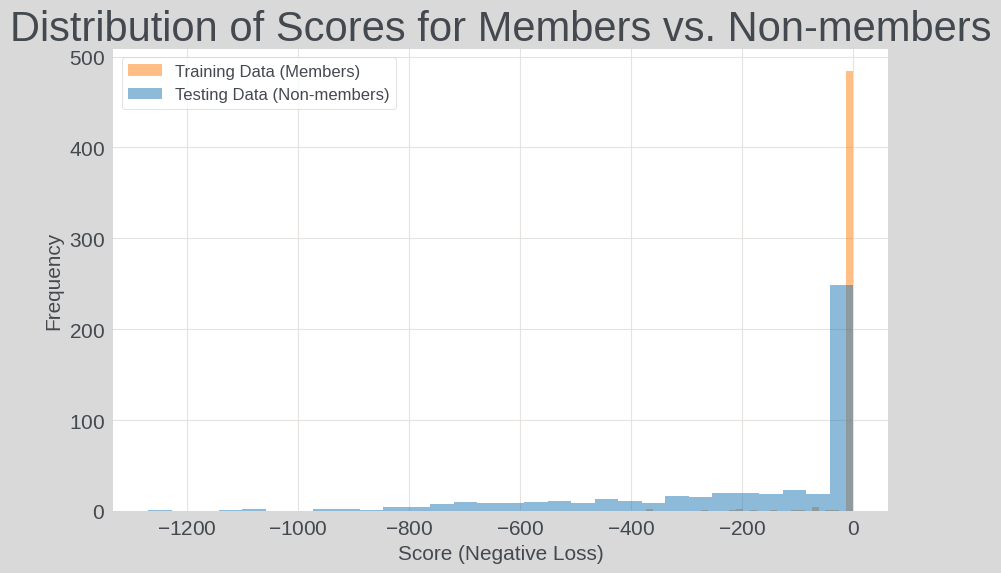

In [85]:
plt.figure(figsize=(10, 6))

# Get the scores
train_scores = attack_results.df_train_user['score']
test_scores = attack_results.df_test_user['score']

# Plot histograms
plt.hist(train_scores, bins=30, alpha=0.5, label='Training Data (Members)', color="tab:orange")
plt.hist(test_scores, bins=30, alpha=0.5, label='Testing Data (Non-members)', color="tab:blue")

plt.xlabel('Score (Negative Loss)')
plt.ylabel('Frequency')
plt.title('Distribution of Scores for Members vs. Non-members')
plt.legend()
plt.grid(True)
plt.show()

We see that it is easy to separate the members from non-members using a threshold.

## Analyzing the Attack Results with AnalysisNode

Now, let's use the `AnalysisNode` class to analyze the results of our attack. This class provides various metrics to evaluate the effectiveness of the attack, such as accuracy, AUC, and privacy leakage measured by epsilon.

In [96]:
# Create a AnalysisNode
analysis_node = AnalysisNode(
    analysis_input=attack_results,
    delta=1e-5,  # Small delta value for privacy calculations
    n_users_for_eval=min(len(attack_results.df_train_user), len(attack_results.df_test_user)),
    num_bootstrap_resampling_times=10000,
    show_progress=True,
    use_fnr_tnr=True,
)

# Run the analysis
analysis_results = analysis_node.run_analysis()

# Print the results
print(f"Attack Accuracy: {analysis_results.accuracy:.4f} (95% CI: [{analysis_results.accuracy_ci[0]:.4f}, {analysis_results.accuracy_ci[1]:.4f}])")
print(f"Attack AUC: {analysis_results.auc:.4f} (95% CI: [{analysis_results.auc_ci[0]:.4f}, {analysis_results.auc_ci[1]:.4f}])")
print(f"Privacy Leakage (Epsilon): {analysis_results.eps:.4f}")
print(f"Epsilon at 1% TPR (Upper Bound): {analysis_results.eps_tpr_ub[0]:.6f}")
print(f"Epsilon at 1% TPR (Lower Bound): {analysis_results.eps_tpr_lb[0]:.6f}")

I0924 075421.657 analysis_node.py:217] Train/Test unique users: 500/500


I0924 075421.673 mia_results.py:187] TNR: 0.284, FNR: 0.0, emp eps: 2.74927, tnr@fnr0.001: 0.284, eps@fnr0.001: 0.24525, auc 0.78407 accuracy 0.776, 


I0924 075421.673 analysis_node.py:224] Epsilon CP: 2.7492718213052085


100%|██████████| 10000/10000 [00:12<00:00, 779.72it/s]


Attack Accuracy: 0.7650 (95% CI: [0.7420, 0.7880])
Attack AUC: 0.7688 (95% CI: [0.7455, 0.7917])
Privacy Leakage (Epsilon): 0.8990
Epsilon at 1% TPR (Upper Bound): 0.899047
Epsilon at 1% TPR (Lower Bound): 0.695227


In the above, we set the adversary's error rate to be 1% TPR, and find a score threshold that corresonds to a 1% TPR. Using that score threshold, the adversary outputs its "member" versus "non-member" guesses. We iterate over error thresholds [1%, 2%, ..., 100%]. We can additionally compute score thresholds using TNR, FNR, and TPR errors. The eps_max entry in the output gives the maximum epsilon over all such error types at different error thresholds. When considering all error types, we obtain an even higher epsilon. Epsilon values are capped at $ln(n)$. We obtain empirical epsilon of $\ln(n)$ due to the strong separation between scores.  

In [98]:
print(f"Epsilon at 1% error rate (Upper Bound): {analysis_results.eps_max_ub[0]:.6f}")
print(f"Epsilon at 1% error rate (Lower Bound): {analysis_results.eps_max_lb[0]:.6f}")

Epsilon at 1% error rate (Upper Bound): 6.214608
Epsilon at 1% error rate (Lower Bound): 6.214608


## Interpreting the Results

Let's interpret the results of our membership inference attack:

### Accuracy and AUC

- **Accuracy**: This measures the proportion of correctly classified samples (members and non-members). An accuracy of 0.5 is equivalent to random guessing, while an accuracy of 1.0 means perfect classification.
- **AUC (Area Under the ROC Curve)**: This measures the ability of the attack to distinguish between members and non-members across different thresholds. An AUC of 0.5 indicates no discriminative ability, while an AUC of 1.0 indicates perfect discrimination. As AUC is measured using different thresholds, it is thought of as an "average case" performance of the attack.

### Privacy Leakage (Epsilon)

- **Epsilon**: This is a measure of privacy leakage in the context of differential privacy. A higher epsilon value indicates more privacy leakage. In practical terms, it quantifies how much more likely a member is to be correctly identified compared to a non-member.
- **Epsilon at TPR=1%**: This is the epsilon value at a true positive rate (TPR) of 1%. It represents the privacy leakage when the attack correctly identifies only 1% of the members. 

### Interpreting Our Results

Based on the results we obtained:

1. The accuracy is significantly above 0.5, which indicates that the attack is successful in distinguishing between members and non-members.
2. The AUC is significantly above 0.5, which indicates that the attack has good discriminative ability.
3. The epsilon value is high, which indicates significant privacy leakage.

### Mitigating Privacy Risks

To mitigate the privacy risks identified by this attack, you could consider:

1. **Regularization**: Apply stronger regularization to the model to reduce overfitting, which can help reduce the gap between training and testing loss.
2. **Differential Privacy**: Train the model with differential privacy guarantees, which add noise to the training process to limit the influence of individual training samples.
3. **Model Pruning**: Reduce the complexity of the model to prevent it from memorizing the training data.
4. **Early Stopping**: Stop training before the model starts to overfit the training data.